In [1]:
from astropy import units as u
from astropy import constants as const
from astropy import cosmology
import pandas as pd

cosmo = cosmology.Planck15

## get SIDES cat

In [2]:
fname = '/Volumes/Drive/sim_cii/data_catalog/SIDES_cats.p'
df = pickle.load(open(fname, "rb"))
df = df[['redshift', 'ra', 'dec', 'Mhalo']]

In [3]:
df['x'] = df['ra'] * 60 * 60 / 7 - 0.5
df['y'] = df['dec'] * 60 * 60 / 7 - 0.5

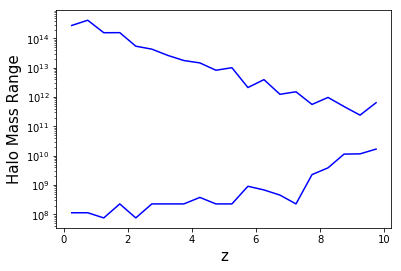

In [4]:
# plot the min and max Mhalo as a function of z

zbinedges = np.arange(0,10.5,0.5)
Mhmin = []
Mhmax = []
for zmin, zmax in zip(zbinedges[:-1], zbinedges[1:]):
    Mhmin.append(min(df["Mhalo"][(df['redshift'] >= zmin) & (df['redshift'] < zmax)]))
    Mhmax.append(max(df["Mhalo"][(df['redshift'] >= zmin) & (df['redshift'] < zmax)]))
plt.plot((zbinedges[:-1] + zbinedges[1:]) / 2, Mhmin, 'b')
plt.plot((zbinedges[:-1] + zbinedges[1:]) / 2, Mhmax, 'b')
plt.yscale('log')
plt.xlabel('z', fontsize=15)
plt.ylabel('Halo Mass Range', fontsize=15)
plt.savefig('plots/Mh_range', dpi = 150)

## Add Virial Radius

In [5]:
z_arr = np.array(df['redshift'])
Mh_arr = np.array(df['Mhalo'])
rhoc_arr = np.array(cosmo.critical_density(z_arr).to(u.M_sun / u.Mpc**3))
rvir_arr = ((3 * Mh_arr) / (4 * np.pi * 200 * rhoc_arr))**(1./3)
DA_arr = np.array(cosmo.comoving_distance(z_arr))
rvir_ang_arr = (rvir_arr / DA_arr) * u.rad.to(u.arcsec)

In [6]:
df['Rv_Mpc'] = rvir_arr
df['Rv_arcsec'] = rvir_ang_arr

In [7]:
df.describe()

,redshift,ra,dec,Mhalo,x,y,Rv_Mpc,Rv_arcsec
count,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06
mean,2.734982e+00,7.039533e-01,6.972193e-01,1.064088e+11,3.615331e+02,3.580699e+02,3.567515e-02,1.826004e+00
std,1.484305e+00,4.041831e-01,4.038262e-01,7.740619e+11,2.078656e+02,2.076821e+02,2.508490e-02,2.718829e+00
min,2.546800e-02,0.000000e+00,0.000000e+00,7.618732e+07,-5.000000e-01,-5.000000e-01,2.377961e-03,5.559002e-02
25%,1.510976e+00,3.536190e-01,3.476190e-01,2.057080e+10,1.813612e+02,1.782755e+02,1.976167e-02,5.844147e-01
50%,2.750341e+00,7.054865e-01,6.967940e-01,3.748378e+10,3.623216e+02,3.578512e+02,2.916379e-02,9.926279e-01
75%,3.610307e+00,1.054712e+00,1.044422e+00,7.359735e+10,5.419236e+02,5.366312e+02,4.411940e-02,2.109581e+00
max,9.993294e+00,1.400000e+00,1.400000e+00,4.190855e+14,7.195000e+02,7.195000e+02,1.274497e+00,4.637619e+02


## Abundance Matching

In [8]:
# Helgason table 2 data
class bands_class:
    
    '''
    Helgason et al. 2012 table 2
    https://ui.adsabs.harvard.edu/#abs/2012ApJ...752..113H/abstract
    '''
    
    def __init__(self,idx):
        
        name_arr = ['UV','U','B','V','R','I','z','J','H','K','L','M']
        wleff_arr = [0.15,0.36,0.45,0.55,0.65,0.79,0.91,1.27,1.63,2.20,3.60,4.50]
        zmax_arr = [8.0,4.5,4.5,3.6,3.0,3.0,2.9,3.2,3.2,3.8,0.7,0.7]
        M0_arr = [-19.62,-20.20,-21.35,-22.13,-22.40,-22.80,-22.86,-23.04,-23.41,-22.97,-22.40,-21.84]
        q_arr = [1.1,1.0,0.6,0.5,0.5,0.4,0.4,0.4,0.5,0.4,0.2,0.3]
        phi0_arr = [2.43,5.46,3.41,2.42,2.25,2.05,2.55,2.21,1.91,2.74,3.29,3.29]
        p_arr = [0.2,0.5,0.4,0.5,0.5,0.4,0.4,0.6,0.8,0.8,0.8,0.8]
        alpha0_arr = [-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00]
        r_arr = [0.086,0.076,0.055,0.060,0.070,0.070,0.060,0.035,0.035,0.035,0.035,0.035]
        
        self.name = name_arr[idx]
        self.wleff = wleff_arr[idx]
        self.zmax = zmax_arr[idx]
        self.M0 = M0_arr[idx]
        self.q = q_arr[idx]
        self.phi0 = phi0_arr[idx]
        self.p = p_arr[idx]
        self.alpha0 = alpha0_arr[idx]
        self.r = r_arr[idx]
        
        self._name_arr = np.asarray(name_arr)
        self._wleff_arr = np.asarray(wleff_arr)
        self._zmax_arr = np.asarray(zmax_arr)
        self._M0_arr = np.asarray(M0_arr)
        self._q_arr = np.asarray(q_arr)
        self._phi0_arr = np.asarray(phi0_arr)
        self._p_arr = np.asarray(p_arr)
        self._alpha0_arr = np.asarray(alpha0_arr)
        self._r_arr = np.asarray(r_arr)

In [9]:
# add z bin label

wlbinedges_arr = (bands_class(0)._wleff_arr[1:] + bands_class(0)._wleff_arr[:-1])/2
wlbinedges_arr = np.concatenate(([0.01],wlbinedges_arr,[20]))

yzbinedges_arr = 0.9633 / wlbinedges_arr - 1
Izbinedges_arr = 1.05 / wlbinedges_arr - 1
Hzbinedges_arr = 1.79 / wlbinedges_arr - 1
yzbinedges_arr[0] = 10.
Izbinedges_arr[0] = 10.
Hzbinedges_arr[0] = 10.

zbinedges_arr = np.concatenate(([0],np.logspace(-1,1,20)))
zbins_arr = (zbinedges_arr[1:] + zbinedges_arr[:-1]) / 2
yidx_arr = np.digitize(zbins_arr,yzbinedges_arr) - 1
Iidx_arr = np.digitize(zbins_arr,Izbinedges_arr) - 1
Hidx_arr = np.digitize(zbins_arr,Hzbinedges_arr) - 1
df['zbin'] = np.digitize(df['redshift'].values,zbinedges_arr) - 1

In [10]:
# Helgason LF helper functions

def Helgason_LF(z, M_arr, bandidx):
    '''
    Helgason + 2012
    rest frame luminosity function [#/mag/Mpc^3].
    Helgason eq 1, eq 3~5, table 2
    '''
    params = bands_class(bandidx)
    Mstr = params.M0 - 2.5 * np.log10((1 + (z - 0.8))**params.q)
    phistr = params.phi0 * np.exp(-params.p * (z - 0.8)) * 1e-3
    alpha = params.alpha0 * (z / 0.01)**params.r
    phi_arr = 0.4 * np.log(10) * phistr * (10**(0.4 * (Mstr - M_arr)))**(alpha + 1) \
            * np.exp(-10**(0.4 * (Mstr - M_arr)))
    return phi_arr

def Helgason_LFcum(z, M_arr, bandidx, dM = 0.01):
    '''
    dN(<M)/dV[1/Mpc^3]
    '''
    M1_arr = np.arange(M_arr[0]-1, M_arr[-1] + dM, dM)
    phi_arr = Helgason_LF(z, M1_arr, bandidx)
    phicum_arr = [np.sum(phi_arr[M1_arr < Mi]) for Mi in M_arr]
    phicum_arr = np.asarray(phicum_arr) * dM
    return phicum_arr
    
def sides_comoving_vol(zmin, zmax):
    '''
    comoving volumn between z1, z2
    '''
    Xmin = cosmo.comoving_distance(zmin)
    Xmax = cosmo.comoving_distance(zmax)
    Dmin = (1.4 * u.degree * cosmo.kpc_comoving_per_arcmin(zmin)).to(u.Mpc)
    Dmax = (1.4 * u.degree * cosmo.kpc_comoving_per_arcmin(zmax)).to(u.Mpc)
    dV = (Dmax**2 * Xmax)/3 - (Dmin**2 * Xmin)/3
    return dV

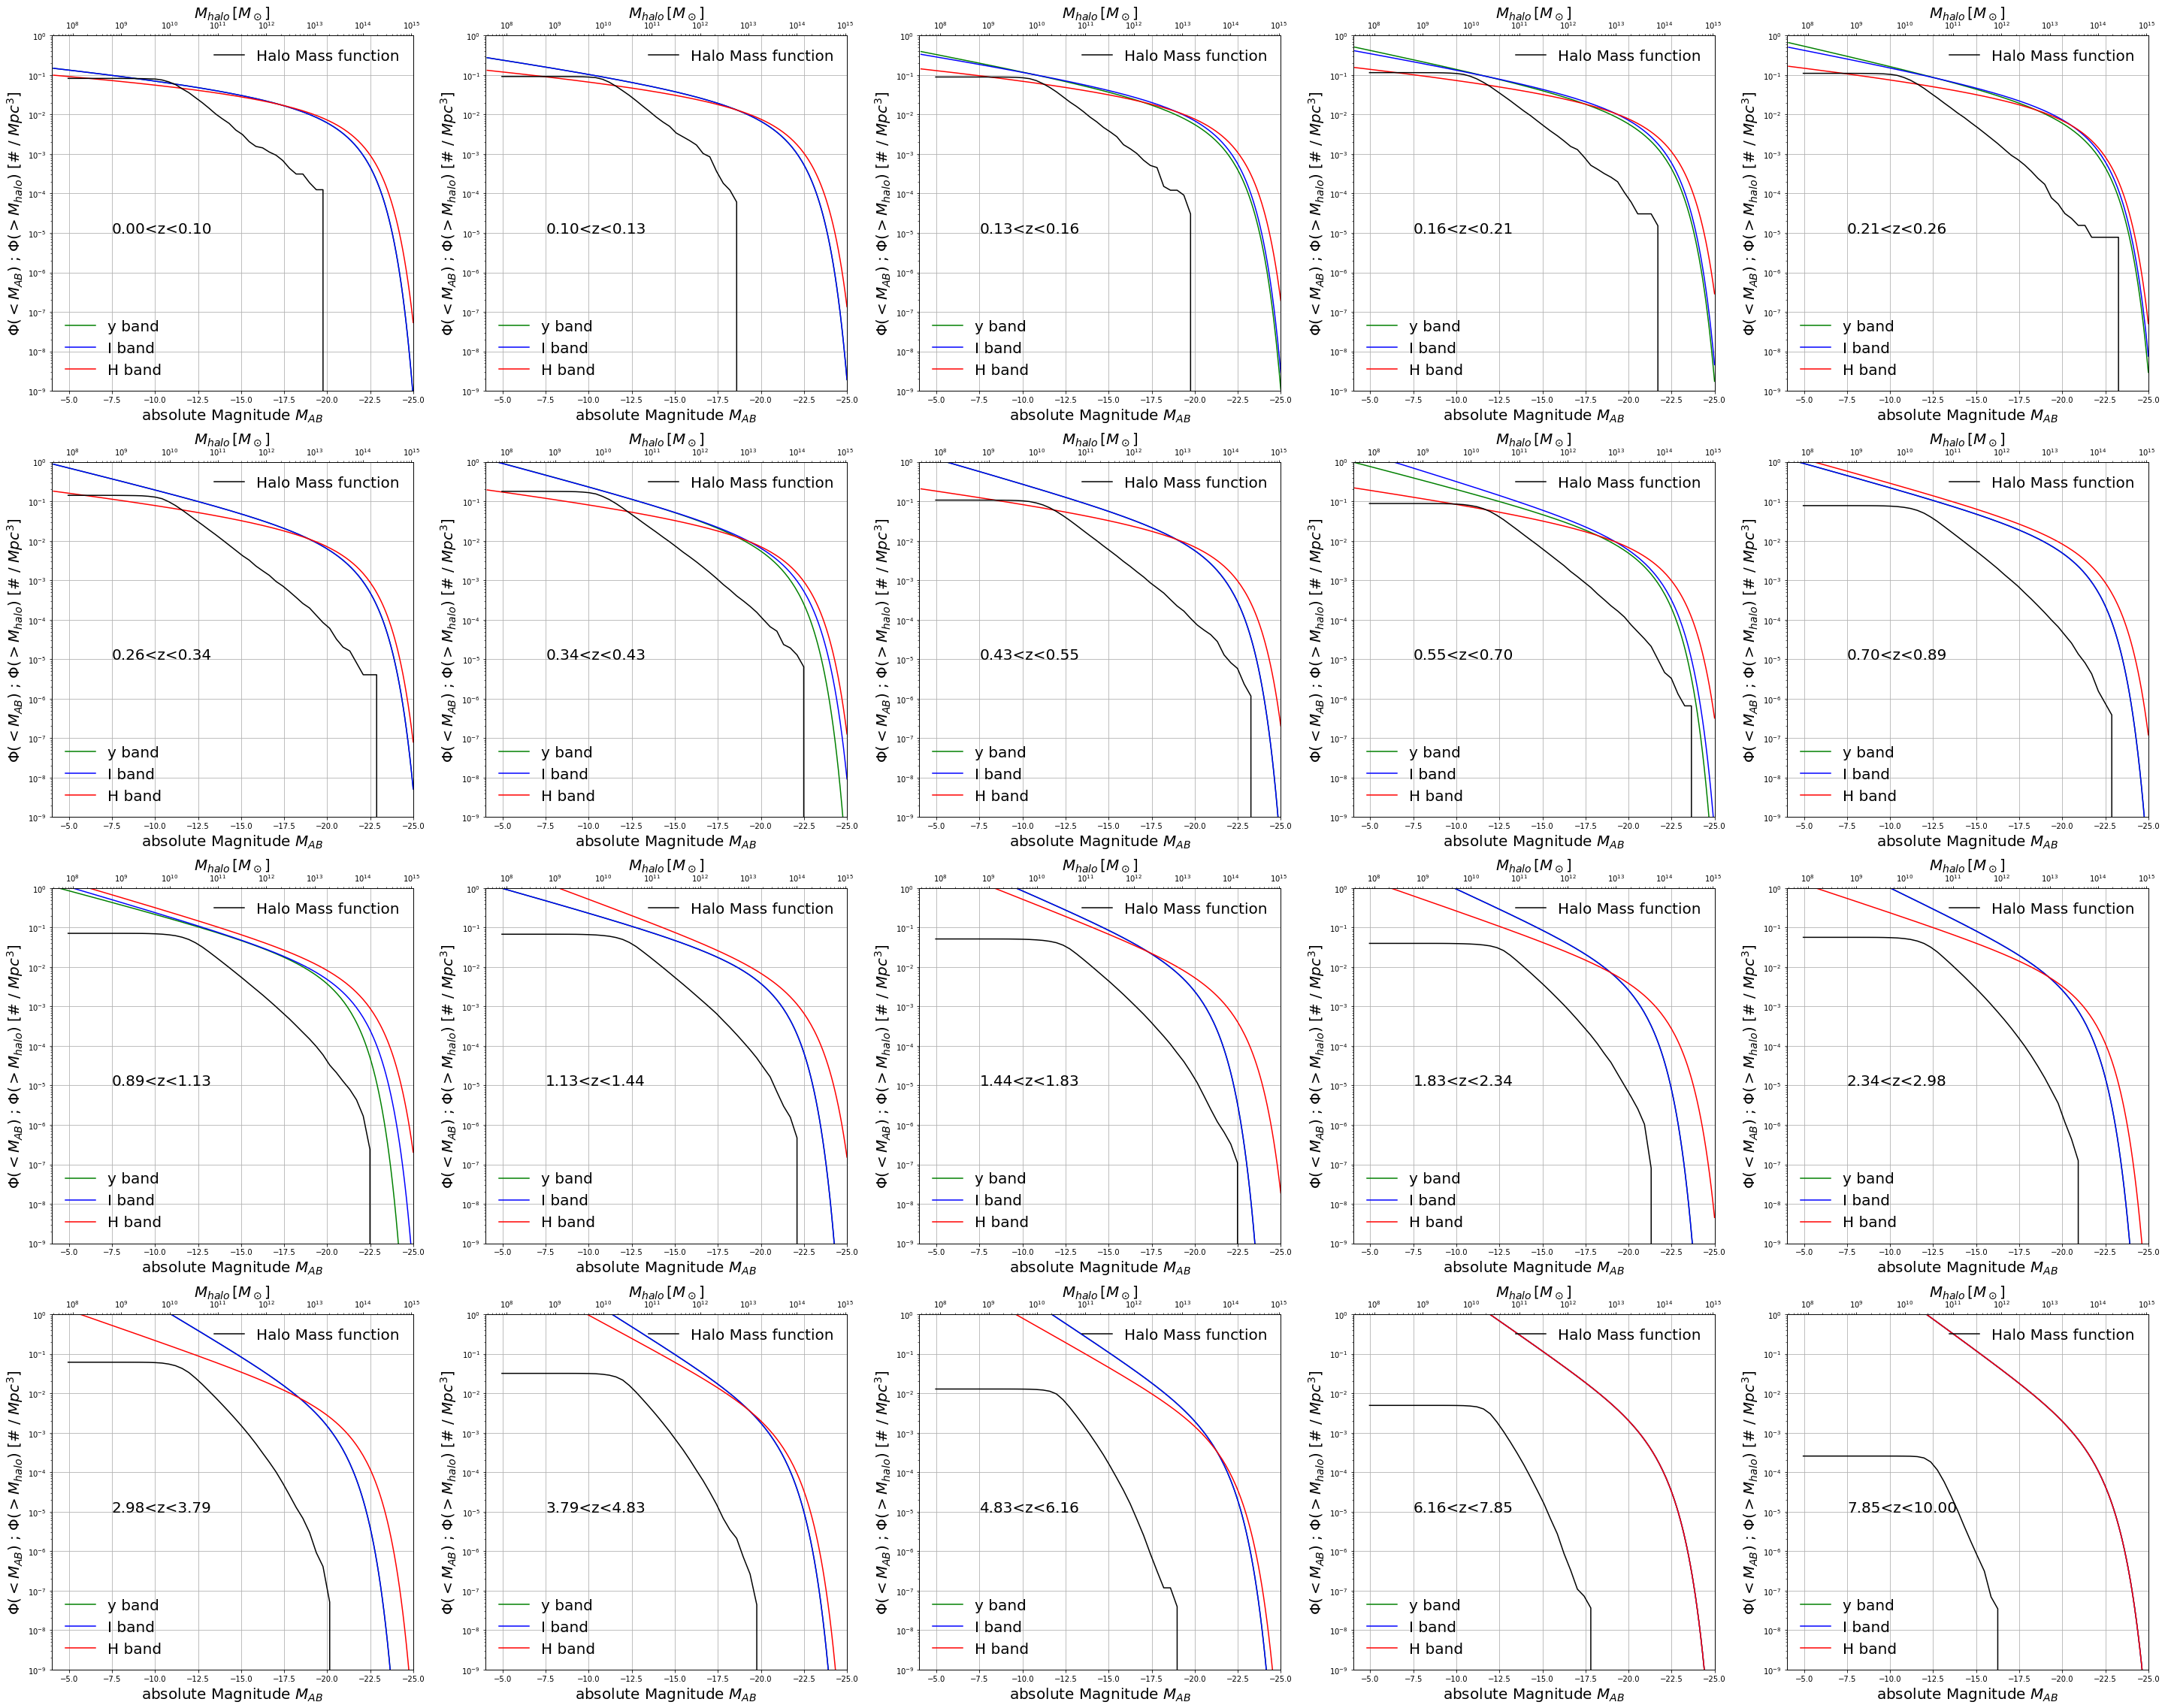

In [11]:
# interpolate to get the y, I, H band absolute mag 

M_arr = np.arange(-25,-4,0.1)
Mh_arr = np.logspace(np.log10(8e7),np.log10(5e14),50)

My_arr = np.ones(len(df)) * -999.
MI_arr = np.ones(len(df)) * -999.
MH_arr = np.ones(len(df)) * -999.

fig = plt.figure(figsize=(50,40))
for zidx in range(len(zbins_arr)):
    
    ax1 = fig.add_subplot(4,5,zidx+1)
    ax2 = ax1.twiny()

    ybandidx = yidx_arr[zidx]
    Ibandidx = Iidx_arr[zidx]
    Hbandidx = Hidx_arr[zidx]
    zmin = zbinedges_arr[zidx]
    zmax = zbinedges_arr[zidx + 1]
    zmid = (zmin + zmax) / 2
    dV = sides_comoving_vol(zmin, zmax).value
    
    yphi_arr = Helgason_LFcum(zmid, M_arr, ybandidx)
    Iphi_arr = Helgason_LFcum(zmid, M_arr, Ibandidx)
    Hphi_arr = Helgason_LFcum(zmid, M_arr, Hbandidx)
    
    sp = np.where((df.redshift >= zmin) & (df.redshift < zmax))[0]
    Mhs = df[(df.redshift >= zmin) & (df.redshift < zmax)].Mhalo.values
    HMF_arr = [len(Mhs[Mhs > Mi]) for Mi in Mh_arr]
    HMF_arr = np.asarray(HMF_arr) / dV
    
    a = np.log(yphi_arr)
    phi_interp_arr = np.exp(np.interp(np.log(Mhs), np.log(Mh_arr[HMF_arr > 0]), np.log(HMF_arr[HMF_arr > 0])))
    My_arr[sp] = np.interp(np.log(phi_interp_arr), np.log(yphi_arr), M_arr) 
    MI_arr[sp] = np.interp(np.log(phi_interp_arr), np.log(Iphi_arr), M_arr) 
    MH_arr[sp] = np.interp(np.log(phi_interp_arr), np.log(Hphi_arr), M_arr) 

    
    ax1.plot(M_arr, yphi_arr,'g', label = 'y band')
    ax1.plot(M_arr, Iphi_arr,'b', label = 'I band')
    ax1.plot(M_arr, Hphi_arr,'r', label = 'H band')
    ax2.plot(Mh_arr, HMF_arr,'k', label = 'Halo Mass function')

    ax1.set_xlim([-4,-25])
    ax2.set_ylim([1e-9,1e0])
    ax2.set_xscale('log')
    ax2.set_yscale('log')    

    ax1.grid()    
    ax1.set_ylabel(r'$\Phi (<M_{AB})$ ; $\Phi (>M_{halo})$ [# / $Mpc^3$]',fontsize = 20)
    ax1.set_xlabel(r'absolute Magnitude $M_{AB}$',fontsize = 20)
    ax2.set_xlabel(r'$M_{halo}\, [M_\odot]$',fontsize = 20)
    ax1.legend(loc=3,frameon = False, fontsize = 20)
    ax2.legend(loc=1,frameon = False, fontsize = 20)
    ax1.text(-7.5, 1e-5, '%.2f<z<%.2f'%(zmin,zmax), fontsize = 20)

df['My'] = My_arr
df['MI'] = MI_arr
df['MH'] = MH_arr

plt.savefig('plots/abundance_matching.png')

In [12]:
# add the apparent magnitude

z_arr = df['redshift'].values
DM_arr = 5 * np.log10((cosmo.luminosity_distance(z_arr) / (10 * u.pc)).decompose())
df['my'] = df['My'] + DM_arr - (2.5 * np.log10(1 + z_arr))
df['mI'] = df['MI'] + DM_arr - (2.5 * np.log10(1 + z_arr))
df['mH'] = df['MH'] + DM_arr - (2.5 * np.log10(1 + z_arr))

In [13]:
df.head()

,redshift,ra,dec,Mhalo,x,y,Rv_Mpc,Rv_arcsec,zbin,My,MI,MH,my,mI,mH
0,0.027082,1.386314,0.578664,9.755162e+11,712.461486,297.098629,0.207339,359.087121,0,-21.855853,-21.855853,-22.269828,13.552696,13.552696,13.138721
1,0.029516,0.454959,1.145274,9.693363e+11,233.478914,588.498057,0.206740,328.712354,0,-21.852044,-21.852044,-22.265931,13.744712,13.744712,13.330825
2,0.028948,0.653517,1.053531,3.458112e+11,335.594457,541.315943,0.146653,237.718788,0,-21.102467,-21.102467,-21.498212,14.451786,14.451786,14.056041
3,0.027158,0.931048,0.651234,3.478761e+11,478.324686,334.420343,0.147028,253.927714,0,-21.111111,-21.111111,-21.507211,14.303565,14.303565,13.907465
4,0.028611,0.787421,0.940826,3.362242e+11,404.459371,483.353371,0.145301,238.281907,0,-21.059828,-21.059828,-21.454055,14.468815,14.468815,14.074588


In [14]:
df.describe()

,redshift,ra,dec,Mhalo,x,y,Rv_Mpc,Rv_arcsec,zbin,My,MI,MH,my,mI,mH
count,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06,5.584998e+06
mean,2.734982e+00,7.039533e-01,6.972193e-01,1.064088e+11,3.615331e+02,3.580699e+02,3.567515e-02,1.826004e+00,1.338059e+01,-1.720329e+01,-1.722707e+01,-1.673644e+01,2.778624e+01,2.776246e+01,2.825309e+01
std,1.484305e+00,4.041831e-01,4.038262e-01,7.740619e+11,2.078656e+02,2.076821e+02,2.508490e-02,2.718829e+00,2.813164e+00,1.764695e+00,1.748770e+00,2.431899e+00,1.656403e+00,1.674574e+00,2.364693e+00
min,2.546800e-02,0.000000e+00,0.000000e+00,7.618732e+07,-5.000000e-01,-5.000000e-01,2.377961e-03,5.559002e-02,0.000000e+00,-2.421248e+01,-2.425612e+01,-2.497623e+01,1.343418e+01,1.343418e+01,1.301435e+01
25%,1.510976e+00,3.536190e-01,3.476190e-01,2.057080e+10,1.813612e+02,1.782755e+02,1.976167e-02,5.844147e-01,1.200000e+01,-1.831756e+01,-1.832791e+01,-1.820112e+01,2.691444e+01,2.689065e+01,2.688827e+01
50%,2.750341e+00,7.054865e-01,6.967940e-01,3.748378e+10,3.623216e+02,3.578512e+02,2.916379e-02,9.926279e-01,1.400000e+01,-1.707408e+01,-1.708226e+01,-1.667771e+01,2.806527e+01,2.804273e+01,2.838453e+01
75%,3.610307e+00,1.054712e+00,1.044422e+00,7.359735e+10,5.419236e+02,5.366312e+02,4.411940e-02,2.109581e+00,1.500000e+01,-1.610614e+01,-1.611876e+01,-1.536090e+01,2.904685e+01,2.903054e+01,2.981548e+01
max,9.993294e+00,1.400000e+00,1.400000e+00,4.190855e+14,7.195000e+02,7.195000e+02,1.274497e+00,4.637619e+02,1.900000e+01,-8.845817e+00,-8.845817e+00,-4.694715e+00,3.062091e+01,3.063585e+01,3.682059e+01


In [15]:
df.drop(['ra', 'dec', 'zbin', 'My', 'MI', 'MH', 'Rv_Mpc'], axis=1, inplace=True)

In [18]:
df = df[['redshift', 'x', 'y', 'Rv_arcsec', 'my', 'mI', 'mH', 'Mhalo']]

In [19]:
df.head()

,redshift,x,y,Rv_arcsec,my,mI,mH,Mhalo
0,0.027082,712.461486,297.098629,359.087121,13.552696,13.552696,13.138721,9.755162e+11
1,0.029516,233.478914,588.498057,328.712354,13.744712,13.744712,13.330825,9.693363e+11
2,0.028948,335.594457,541.315943,237.718788,14.451786,14.451786,14.056041,3.458112e+11
3,0.027158,478.324686,334.420343,253.927714,14.303565,14.303565,13.907465,3.478761e+11
4,0.028611,404.459371,483.353371,238.281907,14.468815,14.468815,14.074588,3.362242e+11


## save the catalog

In [20]:
fname='../../doc/20170617_Stacking/maps/catcoord/SIDES/sides.txt'
df.to_csv(fname,index=False, float_format='%.6f')

# Plot

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy import cosmology
import pandas as pd

cosmo = cosmology.Planck15

In [2]:
fname='../../doc/20170617_Stacking/maps/catcoord/SIDES/sides.txt'
df = pd.read_csv(fname)

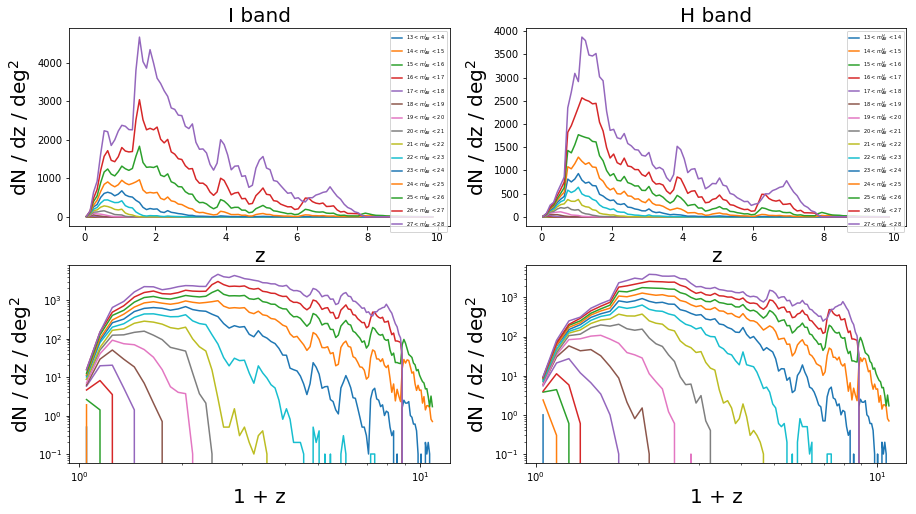

In [3]:
# plot zkernel

fig, ax = plt.subplots(2, 2, figsize=(15,8))
m_bins = np.arange(13,29)
histedges_arr = np.logspace(-2,1,25)
dz = histedges_arr[1:] - histedges_arr[:-1]
dz = 0.1
histedges_arr = np.arange(0,10,dz)
histz_arr = (histedges_arr[1:] + histedges_arr[:-1]) / 2

for i in range(len(m_bins)-1):
    m_min = m_bins[i]
    m_max = m_bins[i+1]

    sp = (df['mI']>m_min) & (df['mI']<m_max)
    z = df['redshift'][sp]
    hist_arr = np.histogram(z, histedges_arr)[0]
    ax[0][0].plot(histz_arr,hist_arr * dz, label = r'%d < $m_{AB}^I$ < %d'%(m_min,m_max))
    ax[1][0].plot(1 + histz_arr,hist_arr * dz)

    sp = (df['mH']>m_min) & (df['mH']<m_max)
    z = df['redshift'][sp]
    hist_arr = np.histogram(z, histedges_arr)[0]
    ax[0][1].plot(histz_arr,hist_arr * dz, label = r'%d < $m_{AB}^H$ < %d'%(m_min,m_max))
    ax[1][1].plot(1 + histz_arr,hist_arr * dz)

ax[0][0].set_xlabel('z', fontsize = 20)
ax[0][0].set_ylabel('dN / dz / deg$^2$', fontsize = 20)
ax[0][0].legend(loc=1,fontsize = 5)
ax[0][0].set_title('I band', fontsize = 20)
ax[0][1].set_xlabel('z', fontsize = 20)
ax[0][1].set_ylabel('dN / dz / deg$^2$', fontsize = 20)
ax[0][1].legend(loc=1,fontsize = 5)
ax[0][1].set_title('H band', fontsize = 20)

ax[1][0].set_xlabel('1 + z', fontsize = 20)
ax[1][0].set_ylabel('dN / dz / deg$^2$', fontsize = 20)
ax[1][0].set_xscale('log')
ax[1][0].set_yscale('log')
ax[1][1].set_xlabel('1 + z', fontsize = 20)
ax[1][1].set_ylabel('dN / dz / deg$^2$', fontsize = 20)
ax[1][1].set_xscale('log')
ax[1][1].set_yscale('log')
plt.savefig('plots/zkernel.png', bbox_inches='tight', dpi = 150)

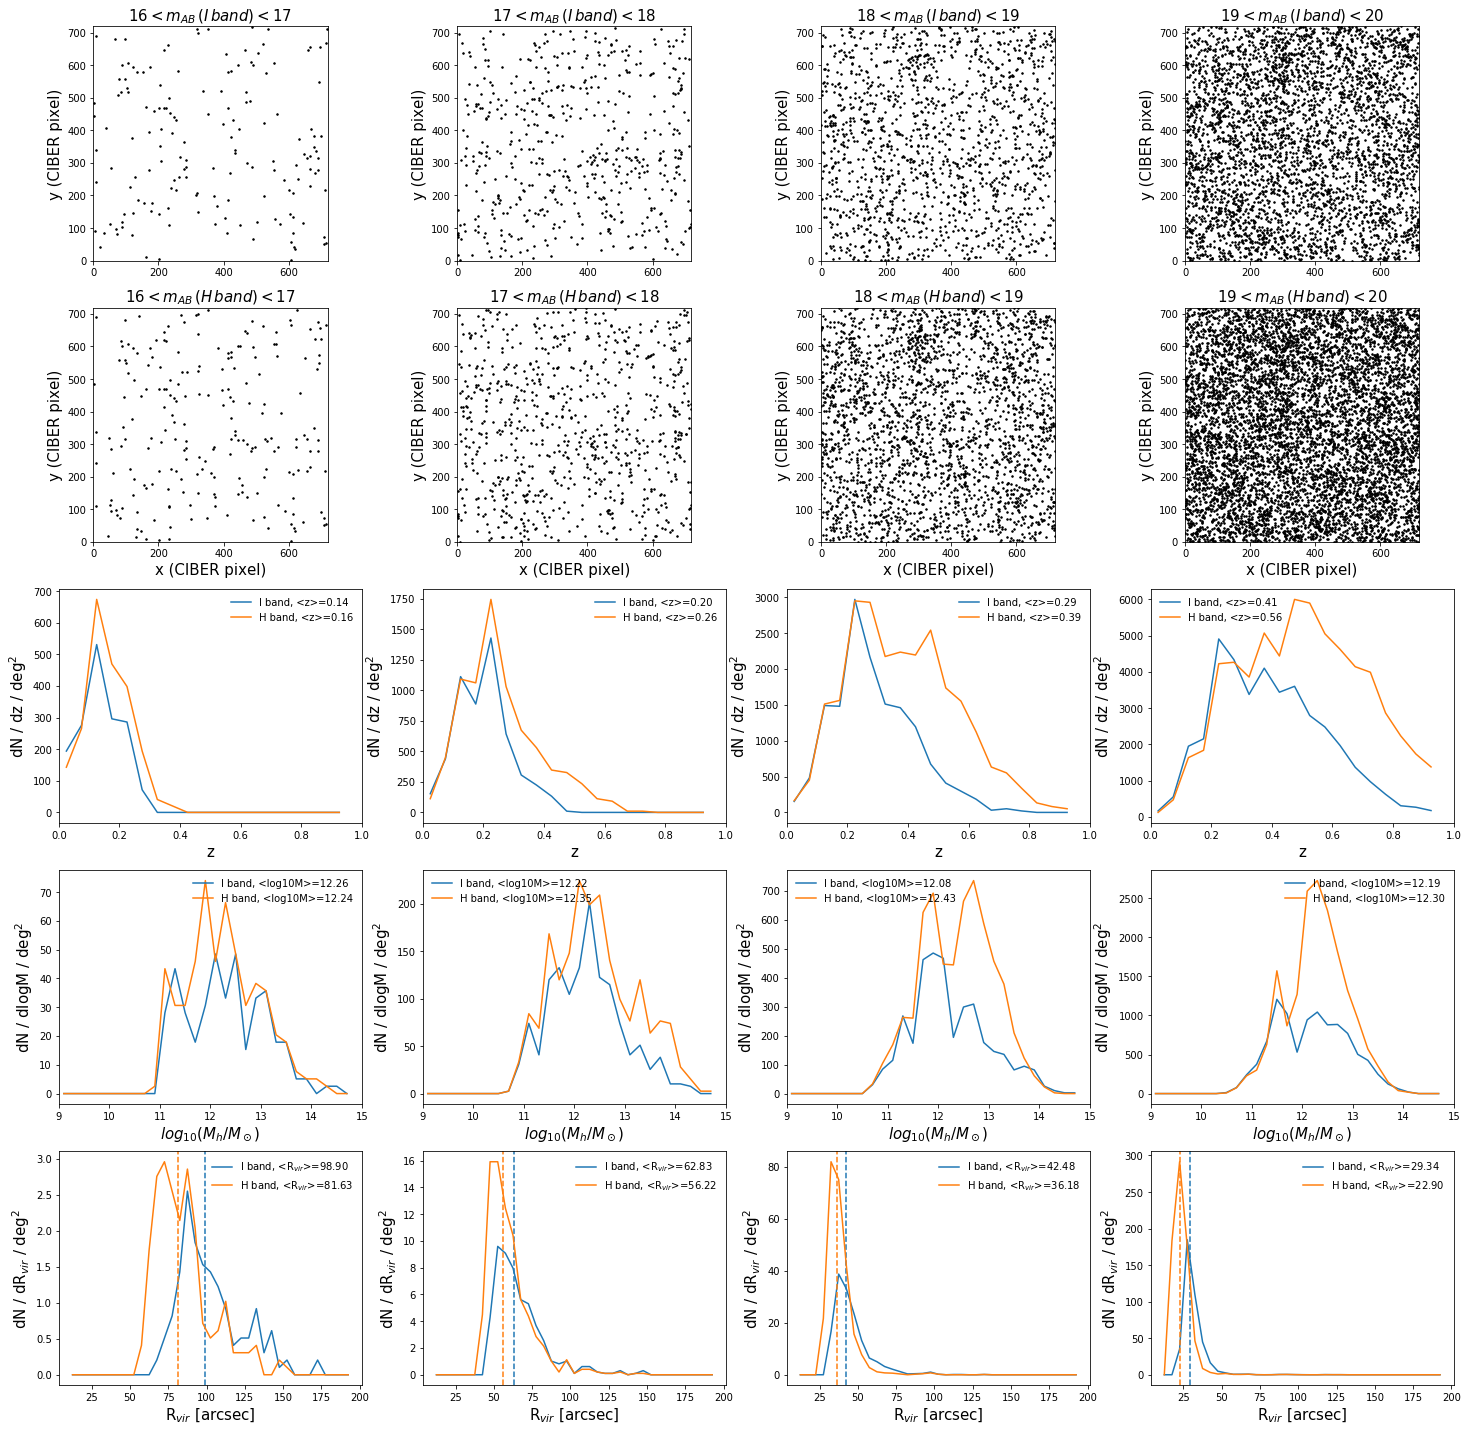

In [9]:
# plot distribution

fig, ax = plt.subplots(5,4,figsize=(25,25))
m_bins = np.arange(16,21)
for i in range(len(m_bins)-1):
    m_min = m_bins[i]
    m_max = m_bins[i+1]
    
    spI = (df['mI'] > m_min) & (df['mI'] < m_max)
    ax[0][i].plot(df['x'][spI], df['y'][spI], 'k.', markersize = 3)
    ax[0][i].set_title(r'%d$ < m_{AB}\,(I\,band) < $%d'%(m_min, m_max), fontsize = 15)
    ax[0][i].set_ylabel('y (CIBER pixel)', fontsize = 15)
    ax[0][i].set_xlim([-0.5, 719.5])
    ax[0][i].set_ylim([-0.5, 719.5])
    ax[0][i].set_aspect('equal')

    spH = (df['mH'] > m_min) & (df['mH'] < m_max)
    ax[1][i].plot(df['x'][spH], df['y'][spH], 'k.', markersize = 3)
    ax[1][i].set_title(r'%d$ < m_{AB}\,(H\,band) < $%d'%(m_min, m_max), fontsize = 15)
    ax[1][i].set_xlabel('x (CIBER pixel)', fontsize = 15)
    ax[1][i].set_ylabel('y (CIBER pixel)', fontsize = 15)
    ax[1][i].set_xlim([-0.5, 719.5])
    ax[1][i].set_ylim([-0.5, 719.5])
    ax[1][i].set_aspect('equal')

    dz = 0.05
    histedges_arr = np.arange(0,1,dz)
    histz_arr = (histedges_arr[1:] + histedges_arr[:-1]) / 2
    z = df['redshift'][spI]
    ax[2][i].plot(histz_arr,np.histogram(z, histedges_arr)[0] / dz / (1.4**2),
                  label = 'I band, <z>=%.2f'%(np.mean(z)))
    z = df['redshift'][spH]
    ax[2][i].plot(histz_arr,np.histogram(z, histedges_arr)[0] / dz / (1.4**2),
                  label = 'H band, <z>=%.2f'%(np.mean(z)))
    ax[2][i].set_xlabel('z', fontsize = 15)
    ax[2][i].set_ylabel('dN / dz / deg$^2$', fontsize = 15)
    ax[2][i].set_xlim([0,1])
    ax[2][i].legend(loc = 0, frameon = False)

    dlogM = 0.2
    histedges_arr = np.arange(9,15,dlogM)
    histlogM_arr = (histedges_arr[1:] + histedges_arr[:-1]) / 2
    logM = np.log10(df['Mhalo'][spI])
    ax[3][i].plot(histlogM_arr,np.histogram(logM, histedges_arr)[0] / dlogM / (1.4**2), 
                  label = 'I band, <log10M>=%.2f'%(np.median(logM)))
    logM = np.log10(df['Mhalo'][spH])
    ax[3][i].plot(histlogM_arr,np.histogram(logM, histedges_arr)[0] / dlogM / (1.4**2),
                  label = 'H band, <log10M>=%.2f'%(np.median(logM)))
    ax[3][i].set_xlabel('$log_{10}(M_h/M_\odot)$', fontsize = 15)
    ax[3][i].set_ylabel('dN / dlogM / deg$^2$', fontsize = 15)
    ax[3][i].set_xlim([9,15])
    ax[3][i].legend(loc = 0, frameon = False)

    drv = 5
    histedges_arr = np.arange(10,200,drv)
    histrv_arr = (histedges_arr[1:] + histedges_arr[:-1]) / 2
    rv = df['Rv_arcsec'][spI]
    ax[4][i].plot(histrv_arr,np.histogram(rv, histedges_arr)[0] / drv / (1.4**2), 
                  label = 'I band, <R$_{vir}$>=%.2f'%(np.median(rv)),c='C0')
    ax[4][i].axvline(np.median(rv),c='C0',ls='--')
    rv = df['Rv_arcsec'][spH]
    ax[4][i].plot(histrv_arr,np.histogram(rv, histedges_arr)[0] / drv / (1.4**2),
                  label = 'H band, <R$_{vir}$>=%.2f'%(np.median(rv)),c='C1')
    ax[4][i].axvline(np.median(rv),c='C1',ls='--')
    ax[4][i].set_xlabel('R$_{vir}$ [arcsec]', fontsize = 15)
    ax[4][i].set_ylabel('dN / dR$_{vir}$ / deg$^2$', fontsize = 15)
#     ax[4][i].set_xlim([9,15])
    ax[4][i].legend(loc = 0, frameon = False)

plt.savefig('plots/mag_bins.png')

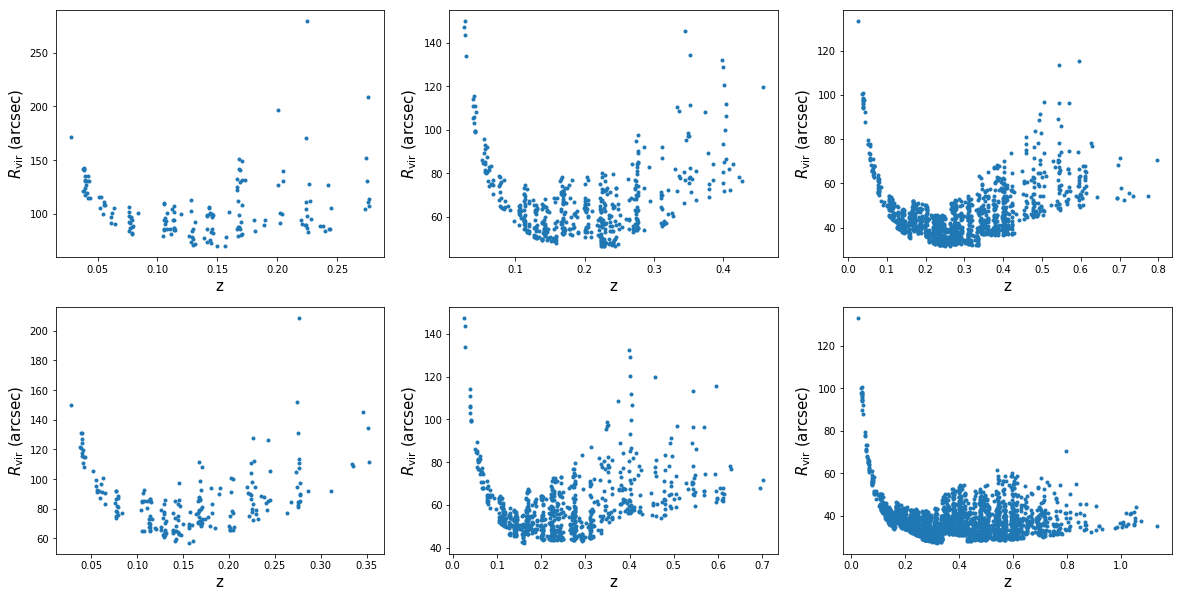

In [101]:
# plot distribution

fig, ax = plt.subplots(2,3,figsize=(20,10))
m_bins = np.arange(16,20)
for i in range(len(m_bins)-1):
    m_min = m_bins[i]
    m_max = m_bins[i+1]
    spI = (df['mI'] > m_min) & (df['mI'] < m_max)
    spH = (df['mH'] > m_min) & (df['mH'] < m_max)
    
    z = df['redshift'][spI]
    Rv = df['Rv_arcsec'][spI]
    ax[0][i].plot(z, Rv, '.')
    ax[0][i].set_xlabel('z', fontsize = 15)
    ax[0][i].set_ylabel(r'$R_{\rm vir}$ (arcsec)', fontsize = 15)
    
    z = df['redshift'][spH]
    Rv = df['Rv_arcsec'][spH]
    ax[1][i].plot(z, Rv, '.')
    ax[1][i].set_xlabel('z', fontsize = 15)
    ax[1][i].set_ylabel(r'$R_{\rm vir}$ (arcsec)', fontsize = 15)
plt.savefig('plots/rvir.png')

## Stars Catalog from Trilegal

In [15]:
fname = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/trilegal/'

# keep only I, H column and save as csv
for field in ['elat10','elat30','BootesB','BootesA','SWIRE']:
    dfs = pd.read_csv(fname + field +'.dat', delim_whitespace=True, usecols=["I","H"])
    dfs.dropna(axis = 0, how = 'any', inplace=True)
    x = np.random.uniform(-0.5, 719.5, len(dfs))
    y = np.random.uniform(-0.5, 719.5, len(dfs))
    dfs['x'] = x
    dfs['y'] = y
    dfs.to_csv(fname + field + '.csv', index=False, float_format='%.6f')

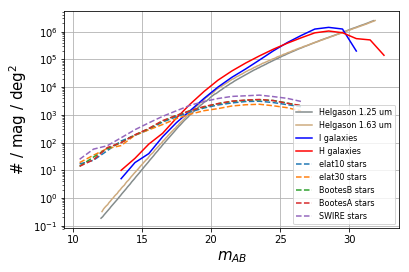

In [17]:
# mag function
# H band star hist is almost overlap with I band star hist, so don't plot it
plt.figure()
helgdir = '/Users/ytcheng/ciber/doc/20170904_External/helgason/'
helgdat = np.loadtxt(helgdir + 'Helgason125.txt', skiprows=1, delimiter=',')
plt.plot(helgdat[:,0],helgdat[:,1], '-', c = '#838B8B', label = 'Helgason 1.25 um')
helgdat = np.loadtxt(helgdir + 'Helgason163.txt', skiprows=1, delimiter=',')
plt.plot(helgdat[:,0],helgdat[:,1], '-',c = '#CDAA7D', label = 'Helgason 1.63 um')

magedge_arr = np.arange(12,34)
mag_arr = (magedge_arr[1:] + magedge_arr[:-1]) / 2

histI_arr = np.histogram(df['mI'].values, magedge_arr)[0]
plt.plot(mag_arr[histI_arr>0],histI_arr[histI_arr>0], 'b', label = 'I galaxies')
histH_arr = np.histogram(df['mH'].values, magedge_arr)[0]
plt.plot(mag_arr[histH_arr>0],histH_arr[histH_arr>0], 'r', label = 'H galaxies')


magedge_arr = np.arange(10,28)
mag_arr = (magedge_arr[1:] + magedge_arr[:-1]) / 2
fname = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/trilegal/'

for field in ['elat10','elat30','BootesB','BootesA','SWIRE']:
    dfs = pd.read_csv(fname + field +'.dat', delim_whitespace=True, usecols=["I","H"])
    dfs.dropna(axis = 0, how = 'any', inplace=True)
    histI_arr = np.histogram(dfs['I'].values, magedge_arr)[0]
    l = plt.plot(mag_arr[histI_arr>0],histI_arr[histI_arr>0], '--', label = field + ' stars')
    #histH_arr = np.histogram(dfs['H'].values, magedge_arr)[0]
    #plt.plot(mag_arr[histH_arr>0],histH_arr[histH_arr>0], '--', c = l[0].get_color(), label = field + 'H stars')

plt.xlabel(r'$m_{AB}$', fontsize = 15)
plt.ylabel(r'# / mag / deg$^2$', fontsize = 15)
plt.yscale('log')
plt.legend(loc=0, fontsize = 8)
plt.grid()
plt.savefig('plots/num_counts.png', dpi = 200)

# sim box size (250 Mpc/h)$^3$ v.s. map size (1.4 deg)$^2$

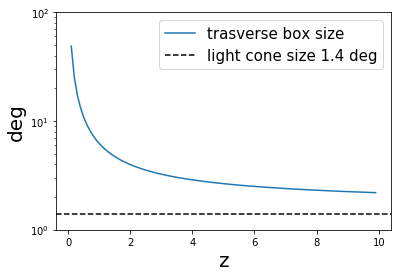

In [76]:
#
z_arr = np.arange(0.1,10,0.1)
th_arr = (250 / cosmo.h * u.Mpc) * cosmo.arcsec_per_kpc_comoving(z_arr).to(u.rad / u.Mpc)
ell_arr = 2 * np.pi / th_arr.value

th_max = 2 * u.deg
ell_min = (2 * np.pi / th_max.to(u.rad)).value

plt.plot(z_arr,th_arr.to(u.deg),label = 'trasverse box size')
plt.yscale('log')
plt.axhline(1.4,color = 'k', ls ='--',label = 'light cone size 1.4 deg')
plt.ylim([1e0,1e2])
plt.xlabel('z', fontsize = 20)
plt.ylabel('deg', fontsize = 20)
plt.legend(loc=0, fontsize = 15)

#plt.savefig('/Users/ytcheng/Desktop/sides_size.png', dpi = 300)

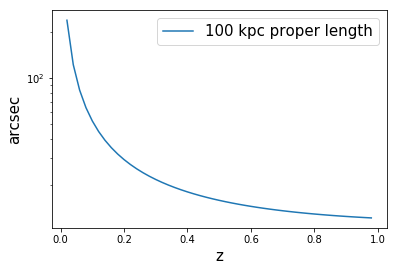

In [28]:
from astropy import units as u
from astropy import constants as const
from astropy import cosmology

cosmo = cosmology.Planck15

z_arr = np.arange(0.02,1,0.02)
plt.plot(z_arr, cosmo.arcsec_per_kpc_proper(z_arr) * [100] * u.kpc, label = '100 kpc proper length')
plt.yscale('log')
plt.xlabel('z', fontsize = 15)
plt.ylabel('arcsec', fontsize = 15)
plt.legend(fontsize = 15)

plt.savefig('/Users/ytcheng/Desktop/ang_scale.png', dpi = 300)